In [1]:
import numpy as np
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cnt1 = [(1117.28949984232, 1931.6519169809123), (1118.2730293316179, 1868.7060296658522), (1162.5318563500196, 1833.2989680511307), (1191.0542115396563, 1793.9577884792182), (1234.3295090687602, 1724.127194739073), (1262.851864258397, 1636.5930701915674), (1288.4236309801402, 1504.80011862566), (1368.0895196132633, 1496.9318827112772), (1424.1507005032388, 1579.548359812294), (1412.348346631665, 1711.3413113782015), (1366.1224606346677, 1830.3483795832374), (1302.1930438303095, 1926.7342695344234), (1269.7365706834817, 2008.3672171461421), (1223.5106846864842, 2037.8731018250767), (1188.1036230717627, 2032.9554543785875), (1148.7624434998502, 1988.6966273601859)]
cnt2 = [(1114.3389113744265, 2030.0048659106942), (1087.7836151633855, 1954.2730952347622), (1132.0424421817872, 1915.9154451521474), (1203.840094900528, 1826.414261626046), (1230.3953911115689, 1734.946019121349), (1246.131862940334, 1677.9013087420756), (1259.9012757905034, 1568.729535430018), (1281.5389245550555, 1491.0307057754903), (1343.5012823808179, 1505.7836481149577), (1369.073049102561, 1580.5318893015917), (1348.418929827307, 1715.2754293353928), (1317.9295156590747, 1911.981327194956), (1286.4565720015446, 2010.3342761247377), (1266.785982215588, 2101.802518629435), (1209.7412718363148, 2130.3248738190714), (1179.2518576680825, 2138.193109733454), (1155.6471499249349, 2092.9507532257544)]

In [ ]:
# cnt2 += np.random.random((len(cnt2), 2)) * 30

In [3]:
def resample_polygon(cnt, n_points=None, len_interval=20):

    polygon = Polygon(cnt)

    if n_points is None:
        contour_length = polygon.exterior.length
        n_points = max(3, int(contour_length / len_interval))

    resampled_cnt = np.empty((n_points, 2))
    for i, p in enumerate(np.linspace(0, 1, n_points+1)[:-1]):
        pt = polygon.exterior.interpolate(p, normalized=True)
        resampled_cnt[i] = (pt.x, pt.y)
    return resampled_cnt


In [4]:
nlevels = 10

In [5]:
def signed_curvatures(s, d=7):
    xp = np.gradient(s[:, 0], d)
    xpp = np.gradient(xp, d)
    yp = np.gradient(s[:, 1], d)
    ypp = np.gradient(yp, d)
    curvatures = (xp * ypp - yp * xpp)/np.sqrt(xp**2+yp**2)**3
    return curvatures, xp, yp

In [6]:
l1 = Polygon(cnt1).length
l2 = Polygon(cnt2).length
n1 = len(cnt1)
n2 = len(cnt2)
len_interval_1 = l1 / n1
len_interval_2 = l2 / n2
len_interval_interpolated = np.linspace(len_interval_1, len_interval_2, nlevels)

len_interval_0 = 20
n_points = max(int(np.round(max(l1, l2) / len_interval_0)), n1, n2)

s1 = resample_polygon(cnt1, n_points=n_points)
s2 = resample_polygon(cnt2, n_points=n_points)

# Make sure point sets are both clockwise or both anti-clockwise.

# c1 = np.mean(s1, axis=0)
# c2 = np.mean(s2, axis=0)
# d1 = (s1 - c1)[0]
# d1 = d1 / np.linalg.norm(d1)
# d2s = s2 - c2
# d2s = d2s / np.sqrt(np.sum(d2s**2, axis=1))[:,None]
# s2_start_index = np.argmax(np.dot(d1, d2s.T))
# print s2_start_index
# s2 = np.r_[np.atleast_2d(s2[s2_start_index:]), np.atleast_2d(s2[:s2_start_index])]

# s2i = np.r_[[s2[0]], s2[1:][::-1]]

s2i = s2[::-1]

curv1, xp1, yp1 = signed_curvatures(s1)
curv2, xp2, yp2 = signed_curvatures(s2)
curv2i, xp2i, yp2i = signed_curvatures(s2i)

# using correlation over curvature values directly is much better than using correlation over signs
# sign1 = np.sign(curv1)
# sign2 = np.sign(curv2)
# sign2i = np.sign(curv2i)

conv_curv_1_2 = np.correlate(np.r_[curv2, curv2], curv1, mode='valid')
conv_xp_1_2 = np.correlate(np.r_[xp2, xp2], xp1, mode='valid')
conv_yp_1_2 = np.correlate(np.r_[yp2, yp2], yp1, mode='valid')

# conv_1_2 = np.correlate(np.r_[sign2, sign2], sign1, mode='valid')

# top, second = conv_1_2.argsort()[::-1][:2]
# d2_top = (s2 - c2)[top]
# d2_top = d2_top / np.linalg.norm(d2_top)
# d2_second = (s2 - c2)[second]
# d2_second = d2_second / np.linalg.norm(d2_second)
# s2_start_index = [top, second][np.argmax(np.dot([d2_top, d2_second], d1))]

conv_curv_1_2i = np.correlate(np.r_[curv2i, curv2i], curv1, mode='valid')
conv_xp_1_2i = np.correlate(np.r_[xp2i, xp2i], xp1, mode='valid')
conv_yp_1_2i = np.correlate(np.r_[yp2i, yp2i], yp1, mode='valid')

# conv_1_2i = np.correlate(np.r_[sign2i, sign2i], sign1, mode='valid')
# top, second = conv_1_2i.argsort()[::-1][:2]
# if xp1[top] * xp2i[top] + yp1[top] * yp2i[top] > xp1[top] * xp2i[top] + yp1[top] * yp2i[top] :
#     s2i_start_index = top
# else:
#     s2i_start_index = second

# d2_top = (s2i - c2)[top]
# d2_top = d2_top / np.linalg.norm(d2_top)
# d2_second = (s2i - c2)[second]
# d2_second = d2_second / np.linalg.norm(d2_second)
# s2i_start_index = [top, second][np.argmax(np.dot([d2_top, d2_second], d1))]

# if conv_1_2[s2_start_index] > conv_1_2i[s2i_start_index]:
#     s3 = np.r_[np.atleast_2d(s2[s2_start_index:]), np.atleast_2d(s2[:s2_start_index])]
# else:
#     s3 = np.r_[np.atleast_2d(s2i[s2i_start_index:]), np.atleast_2d(s2i[:s2i_start_index])]

if conv_curv_1_2.max() > conv_curv_1_2i.max():
    overall = conv_curv_1_2 / conv_curv_1_2.max() + conv_xp_1_2 / conv_xp_1_2.max() + conv_yp_1_2 / conv_yp_1_2.max()
    s2_start_index = np.argmax(overall)
    s3 = np.roll(s2, -s2_start_index, axis=0)
else:
    overall = conv_curv_1_2i / conv_curv_1_2i.max() + conv_xp_1_2i / conv_xp_1_2i.max() + conv_yp_1_2i / conv_yp_1_2i.max()
    s2i_start_index = np.argmax(overall)
    s3 = np.roll(s2i, -s2i_start_index, axis=0)

# plt.plot(overall)
# plt.show();
    
interpolated_contours = [(1-r) * s1 + r * s3 for r in np.linspace(0, 1, nlevels)]
resampled_interpolated_contours = [resample_polygon(cnt, len_interval=len_interval_interpolated[i]) for i, cnt in enumerate(interpolated_contours)]

In [7]:
print conv_curv_1_2.max()
print conv_curv_1_2i.max()

0.00581425804861
0.000954983101552


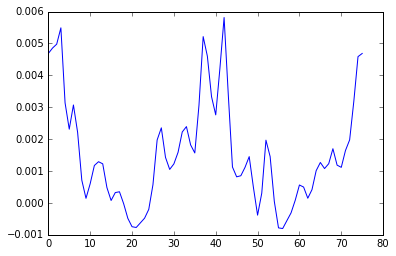

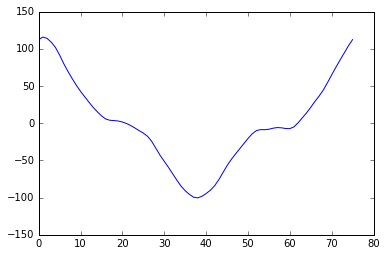

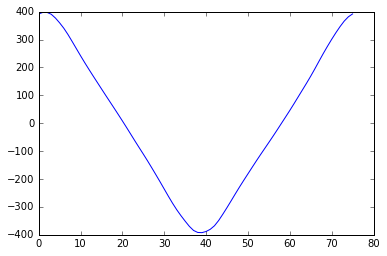

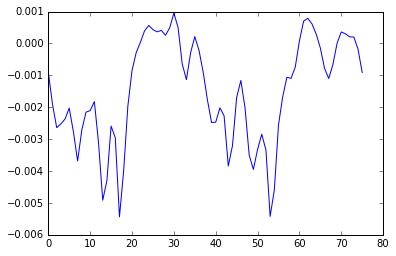

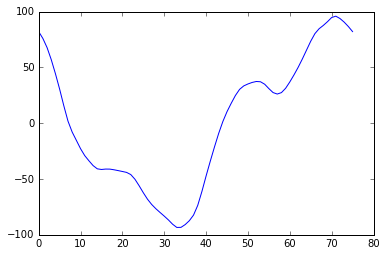

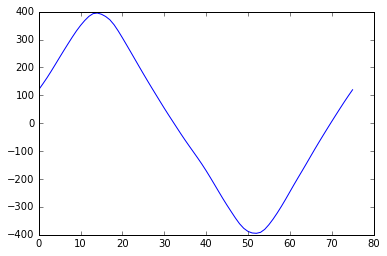

In [8]:
conv_curv_1_2 = np.correlate(np.r_[curv2, curv2], curv1, mode='valid')
plt.plot(conv_curv_1_2)
plt.show()

conv_xp_1_2 = np.correlate(np.r_[xp2, xp2], xp1, mode='valid')
plt.plot(conv_xp_1_2)
plt.show()

conv_yp_1_2 = np.correlate(np.r_[yp2, yp2], yp1, mode='valid')
plt.plot(conv_yp_1_2)
plt.show()

# conv_1_2 = np.correlate(np.r_[sign2, sign2], sign1, mode='valid')
# plt.plot(conv_1_2)
# plt.show()

conv_curv_1_2i = np.correlate(np.r_[curv2i, curv2i], curv1, mode='valid')
plt.plot(conv_curv_1_2i)
plt.show()

conv_xp_1_2i = np.correlate(np.r_[xp2i, xp2i], xp1, mode='valid')
plt.plot(conv_xp_1_2i)
plt.show()

conv_yp_1_2i = np.correlate(np.r_[yp2i, yp2i], yp1, mode='valid')
plt.plot(conv_yp_1_2i)
plt.show()

# conv_1_2 = np.correlate(np.r_[sign2i, sign2i], sign1, mode='valid')
# plt.plot(conv_1_2)
# plt.show()


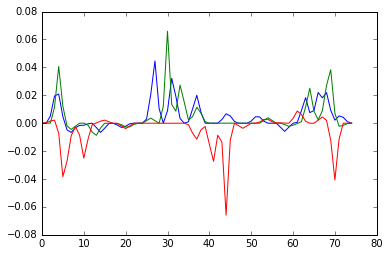

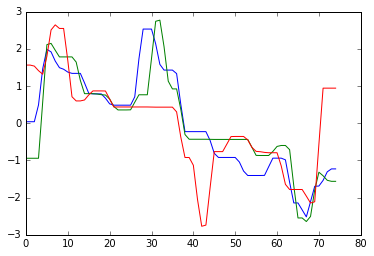

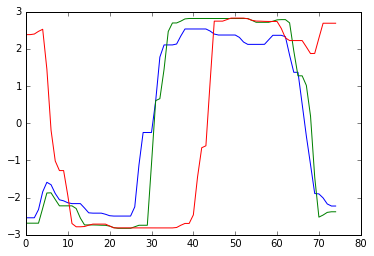

In [9]:
plt.plot(curv1);
plt.plot(curv2);
plt.plot(curv2i);
plt.show()

plt.plot(xp1);
plt.plot(xp2);
plt.plot(xp2i);
plt.show();

plt.plot(yp1);
plt.plot(yp2);
plt.plot(yp2i);
plt.show();

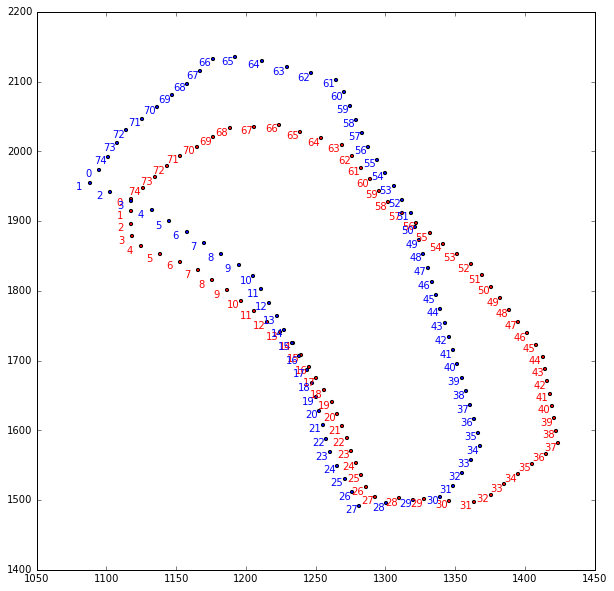

In [10]:
plt.figure(figsize=(10,10));

plt.scatter(s1[:,0], s1[:,1], s=10, c='r')
# plt.scatter(s2i[:,0], s2[:,1], s=10, c='g')
# plt.scatter(s2i[:,0], s2i[:,1], s=10, c='g')
plt.scatter(s3[:,0], s3[:,1], s=10, c='b')

for i, (x, y) in enumerate(s1):
    plt.text(x-10, y-10, str(i), size=10, color='r')

# for i, (x, y) in enumerate(s2):
#     plt.text(x-10, y-10, str(i), size=10, color='g')

# for i, (x, y) in enumerate(s2i):
#     plt.text(x-10, y-10, str(i), size=10, color='g')

for i, (x, y) in enumerate(s3):
    plt.text(x-10, y-10, str(i), size=10, color='b')
    
plt.show()